# **Visual Question Answering**

   **Dataset:** Visual Q/A dataset from Youdata.ai


**Importing Libraries**

Uploading the dataset

In [ ]:
import pandas as pd

# Load the dataset
file_path = '/content/vqa_dataset_large_v1_preview.csv'  # Adjust this path if necessary
df = pd.read_csv(file_path)

# Display the first few rows of the dataset
df.head()


,Unnamed: 0.1,Unnamed: 0,image,extracted_text,correct_option,language
0,0,0,"<p><img src=""data:image/png;base64,/9j/4AAQSkZ...",The upper half of an inclined plane of\ninclin...,D,English
1,1,1,"<p><img src=""data:image/png;base64,/9j/4AAQSkZ...",A projectile is thrown with a velocity of 10\n...,A,English
2,2,2,"<p><img src=""data:image/png;base64,/9j/4AAQSkZ...",A girl riding a bicycle with a speed of 5m\ns-...,A,English
3,3,3,"<p><img src=""data:image/png;base64,/9j/4AAQSkZ...",A body takes time t to reach the bottom\nof an...,A,English
4,4,4,"<p><img src=""data:image/png;base64,/9j/4AAQSkZ...",40.\n\nThe minimum force required to start\npu...,D,English


**Data Preprocessing**

In [ ]:
import base64
from PIL import Image
from io import BytesIO
import os

# Create a directory to save images
os.makedirs('images', exist_ok=True)

def decode_image(image_str, idx):
    base64_str = image_str.split('base64,')[1].split('"')[0]
    image_data = base64.b64decode(base64_str)
    image = Image.open(BytesIO(image_data))
    image_path = f'images/image_{idx}.png'
    image.save(image_path)
    return image_path

df['image_path'] = df.apply(lambda row: decode_image(row['image'], row.name), axis=1)


In [ ]:
# Drop unnecessary columns
df = df.drop(columns=['Unnamed: 0.1', 'Unnamed: 0', 'image'])

# Display the first few rows of the cleaned dataset
df.head()


,extracted_text,correct_option,language,image_path
0,The upper half of an inclined plane of\ninclin...,D,English,images/image_0.png
1,A projectile is thrown with a velocity of 10\n...,A,English,images/image_1.png
2,A girl riding a bicycle with a speed of 5m\ns-...,A,English,images/image_2.png
3,A body takes time t to reach the bottom\nof an...,A,English,images/image_3.png
4,40.\n\nThe minimum force required to start\npu...,D,English,images/image_4.png


**Data Visualization**

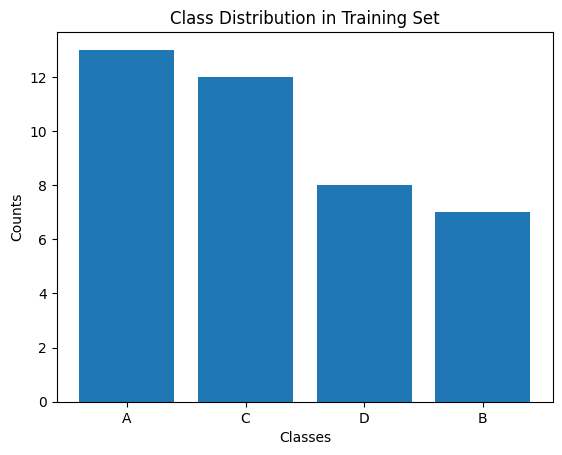

In [ ]:
import matplotlib.pyplot as plt

train_class_counts = train_df['correct_option'].value_counts()
plt.bar(train_class_counts.index, train_class_counts.values)
plt.xlabel('Classes')
plt.ylabel('Counts')
plt.title('Class Distribution in Training Set')
plt.show()


**Model Selection**

Train Test Split


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Split the data into training and testing sets
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

# Encode the labels
label_encoder = LabelEncoder()
train_df['label'] = label_encoder.fit_transform(train_df['correct_option'])
test_df['label'] = label_encoder.transform(test_df['correct_option'])

# Tokenize the text data
tokenizer = Tokenizer(num_words=10000, oov_token="<OOV>")
tokenizer.fit_on_texts(train_df['extracted_text'])

# Convert text to sequences and pad them
train_sequences = tokenizer.texts_to_sequences(train_df['extracted_text'])
train_padded = pad_sequences(train_sequences, padding='post')

test_sequences = tokenizer.texts_to_sequences(test_df['extracted_text'])
test_padded = pad_sequences(test_sequences, padding='post')


In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPooling2D, Flatten, Embedding, LSTM, concatenate
from tensorflow.keras.models import Model

# Define the image model
image_input = Input(shape=(224, 224, 3))
x = Conv2D(32, (3, 3), activation='relu')(image_input)
x = MaxPooling2D((2, 2))(x)
x = Flatten()(x)
image_model = Model(inputs=image_input, outputs=x)

# Define the text model
text_input = Input(shape=(None,), dtype='int32')
y = Embedding(input_dim=10000, output_dim=128)(text_input)
y = LSTM(128)(y)
text_model = Model(inputs=text_input, outputs=y)

# Concatenate the outputs of the two models
combined = concatenate([image_model.output, text_model.output])
z = Dense(128, activation='relu')(combined)
z = Dense(4, activation='softmax')(z)  # Assuming 4 possible answer options (A, B, C, D)

# Define the combined model
model = Model(inputs=[image_model.input, text_model.input], outputs=z)

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])


Accuracy


In [ ]:
import numpy as np
from tensorflow.keras.utils import to_categorical

def data_generator(image_paths, text_data, labels, batch_size):
    while True:
        for start in range(0, len(image_paths), batch_size):
            end = min(start + batch_size, len(image_paths))
            batch_images = []
            batch_texts = text_data[start:end]
            batch_labels = labels[start:end]
            for file_path in image_paths[start:end]:
                image = Image.open(file_path).resize((224, 224))
                image = np.array(image) / 255.0
                batch_images.append(image)
            yield [np.array(batch_images), np.array(batch_texts)], np.array(batch_labels)

# Prepare labels
train_labels = train_df['label']
test_labels = test_df['label']

# Create training and validation generators
train_gen = data_generator(train_df['image_path'].tolist(), train_padded, train_labels, batch_size=32)
val_gen = data_generator(test_df['image_path'].tolist(), test_padded, test_labels, batch_size=32)

# Ensure steps_per_epoch is at least 1
steps_per_epoch = max(len(train_df) // 32, 1)
validation_steps = max(len(test_df) // 32, 1)

# Train the model
model.fit(
    train_gen,
    steps_per_epoch=steps_per_epoch,
    validation_data=val_gen,
    validation_steps=validation_steps,
    epochs=10
)


Epoch 1/10
1/1 [==============================] - 8s 8s/step - loss: 1.5017 - accuracy: 0.2812 - val_loss: 132.0286 - val_accuracy: 0.1000
Epoch 2/10
1/1 [==============================] - 2s 2s/step - loss: 151.3932 - accuracy: 0.1250 - val_loss: 56.4327 - val_accuracy: 0.3000
Epoch 3/10
1/1 [==============================] - 3s 3s/step - loss: 37.1733 - accuracy: 0.3438 - val_loss: 66.7077 - val_accuracy: 0.3000
Epoch 4/10
1/1 [==============================] - 2s 2s/step - loss: 63.5701 - accuracy: 0.3750 - val_loss: 48.2144 - val_accuracy: 0.3000
Epoch 5/10
1/1 [==============================] - 3s 3s/step - loss: 59.2580 - accuracy: 0.1562 - val_loss: 22.9723 - val_accuracy: 0.3000
Epoch 6/10
1/1 [==============================] - 2s 2s/step - loss: 12.9285 - accuracy: 0.3750 - val_loss: 43.4142 - val_accuracy: 0.3000
Epoch 7/10
1/1 [==============================] - 3s 3s/step - loss: 52.3995 - accuracy: 0.1250 - val_loss: 39.9949 - val_accuracy: 0.3000
Epoch 8/10
1/1 [==========

**Model Prediction**

In [ ]:
from PIL import Image
import numpy as np

# Ensure tokenizer and label_encoder are available and trained
# Assume they were trained during the model training phase

# Preprocessing functions
def preprocess_text(question):
    seq = tokenizer.texts_to_sequences([question])
    padded = pad_sequences(seq, maxlen=train_padded.shape[1], padding='post')
    return padded

def preprocess_image(image_path):
    image = Image.open(image_path).resize((224, 224))
    image = np.array(image) / 255.0
    if len(image.shape) == 2:  # handle grayscale images
        image = np.stack((image,) * 3, axis=-1)
    return np.expand_dims(image, axis=0)

# Inference function
def predict(question, image_path):
    processed_text = preprocess_text(question)
    processed_image = preprocess_image(image_path)
    prediction = model.predict([processed_image, processed_text])
    return label_encoder.inverse_transform([np.argmax(prediction)])[0]

# Example usage
question = "The taxonomy category below the level of family is"
image_path = "images/image_20.png"
print(predict(question, image_path))


1/1 [==============================] - 1s 968ms/step
A
